# Variables

1. NearestMonth - Front/Second/etc. month at each respective date - starts from 1
2. backAdjustDays - how many days back we need to adjust       # 0 means expired on the day of expiry

In [1]:
import os
import pandas as pd
import numpy as np
from os import walk
import collections

In [2]:
# Path of all files in folder and subfolder - CONTINUE Folder
List_of_files_continue = []
folder_continue = "C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/dailyContinue/"
folder_names_continue = [os.path.join(folder_continue, name) for name in os.listdir(folder_continue) if os.path.isdir(os.path.join(folder_continue, name))]
folder_names_continue.append(folder_continue)
for fold in folder_names_continue:
    filenames = next(walk(fold), (None, None, []))[2]  # [] if no file
    for file in filenames:
        List_of_files_continue.append(str(fold+"/"+file).replace('//','/'))
List_of_files_continue = [val for val in List_of_files_continue if not val.endswith(".ipynb")] # remove all files end in .ipynb
List_of_files_continue = [val for val in List_of_files_continue if not val.endswith(".pkl")] # remove all files end in .pkl
List_of_files_continue = [val for val in List_of_files_continue if not val.endswith("expiry_df_other_symbols_Continue.csv")]
List_of_files_continue = [val for val in List_of_files_continue if not val.endswith("expiry_df_Continue.csv")]

len(List_of_files_continue)

621

In [3]:
# Path of all files in folder and subfolder - NEAREST Folder
List_of_files_nearest = []
folder_nearest = "C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/"
folder_names_nearest = [os.path.join(folder_nearest, name) for name in os.listdir(folder_nearest) if os.path.isdir(os.path.join(folder_nearest, name))]
folder_names_nearest.append(folder_nearest)
folder_names_nearest.remove("C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/dailyContinue")
folder_names_nearest.remove("C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/Archived CSV Files")
for fold in folder_names_nearest:
    filenames = next(walk(fold), (None, None, []))[2]  # [] if no file
    for file in filenames:
        List_of_files_nearest.append(str(fold+"/"+file).replace('//','/'))
List_of_files_nearest = [val for val in List_of_files_nearest if not val.endswith(".ipynb")] # remove all files end in .ipynb
List_of_files_nearest = [val for val in List_of_files_nearest if not val.endswith(".pkl")] # remove all files end in .pkl
List_of_files_nearest = [val for val in List_of_files_nearest if not val.endswith("combined_dataframe.csv")]
List_of_files_nearest = [val for val in List_of_files_nearest if not val.endswith("expiry_df.csv")]
List_of_files_nearest = [val for val in List_of_files_nearest if not val.endswith("expiry_df_other_symbols.csv")]

len(List_of_files_nearest)

618

In [4]:
# Matching Nearest & Continue FILES - just remove "_Continue" at the end but before ".csv"
# For each file in Nearest, change the string of the path to make it similar to one in Continue and the check if its exits in Continue

file_paths_dict = {}
for file_nearest in List_of_files_nearest:
    continue_string = file_nearest[file_nearest.rindex('/')+1:]
    continue_string = str(continue_string.replace(".csv","")+"_Continue.csv")
    idx_continue = [i for i, s in enumerate(List_of_files_continue) if continue_string in s]
    file_paths_dict[file_nearest] = List_of_files_continue[idx_continue[0]]

len(file_paths_dict.keys())    
        

618

In [5]:
# file_paths_dict['C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/Archived CSV Files/Australian Dollar(P)_daily_price.csv']

In [6]:
# Get Expiry dataframe from csv
expiry_nearest = pd.read_csv("C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/expiry_df.csv", index_col=0)
expiry_nearest.head(2)   

,symbol,exchange,contract,firstNoticeDate,expirationDate,lastTradingDay,Unnamed: 7
MGM22,MGM22,GBLX,_Jun 22,6/13/2022,6/13/2022,Second business day preceding third Wednesday ...,NaN
MGH22,MGH22,GBLX,_Mar 22,3/14/2022,3/14/2022,Second business day preceding third Wednesday ...,NaN


In [7]:
# Collect all contracts for all commodities in a dictionary and a list of dates
all_dates = []
cmdty_ctrct_dict = {}
cmdty_no_data = []
temp_list = []
cmdty_no_expiry = []
cmdty_ctrct_expiry_dict = collections.defaultdict(dict) # If the amount of nesting you need is fixed, use collections.defaultdict.
file_path_cmdty_name = {}

for file in file_paths_dict.keys():
    cmdty_name = file[file.rindex('/')+1:].replace('_daily_price.csv','')
    
    try:
        list_nearest_ctrct = pd.read_csv(file)['symbol'].unique().tolist()
        list_nearest_dates = pd.read_csv(file)['tradingDay'].unique().tolist()

    except:
        cmdty_no_data.append(cmdty_name)
        temp_list.append(file_paths_dict[file])

    try:
        list_continue_ctrct = pd.read_csv(file_paths_dict[file],index_col=0)['symbol'].unique().tolist()
        list_continue_dates = pd.read_csv(file_paths_dict[file],index_col=0)['tradingDay'].unique().tolist()

    except:
        cmdty_no_data.append(cmdty_name)
        temp_list.append(file_paths_dict[file])

    cmdty_ctrct_dict[cmdty_name] = set(list_nearest_ctrct + list_continue_ctrct)
    file_path_cmdty_name[file] = cmdty_name

    all_dates = all_dates + list_nearest_dates + list_continue_dates

    for ctrcts in cmdty_ctrct_dict[cmdty_name]:
        try:
            cmdty_ctrct_expiry_dict[cmdty_name][ctrcts] = expiry_nearest.loc[ctrcts,'expirationDate'], expiry_nearest.loc[ctrcts,'exchange'], expiry_nearest.loc[ctrcts,'contract'].replace('_','')
        except:
            cmdty_no_expiry.append(ctrcts)

        # To do dict of dicts
	
temp_list =  set(temp_list)
all_dates = set(all_dates)
cmdty_no_data = set(cmdty_no_data)
all_dates = pd.Series(pd.DatetimeIndex(all_dates))
all_dates =  all_dates.sort_values(ascending=False).dt.strftime('%Y-%m-%d').tolist()  


In [8]:
# LS_path = 'C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/Lumber_daily_price.csv'

LS_path = 'C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/Crude Oil Brent_daily_price.csv'


file = LS_path

combined = pd.concat([pd.read_csv(file,index_col=0), pd.read_csv(file_paths_dict[file],index_col=0)])
combined.drop_duplicates(inplace=True)
len(combined)


86000

In [9]:
# one_commodity_expiry = pd.DataFrame(cmdty_ctrct_expiry_dict['Lumber']).T
one_commodity_expiry = pd.DataFrame(cmdty_ctrct_expiry_dict['Crude Oil Brent']).T


one_commodity_expiry.columns = ['expiry','exchange','contract']
one_commodity_expiry.expiry = pd.to_datetime(one_commodity_expiry.expiry)
one_commodity_expiry.sort_values(by=['expiry'], ascending= False, inplace=True)
len(one_commodity_expiry)


173

In [10]:
combined_pivot = {}
new_combined_pivot = {}
for ohlcv_opt in ['open','high','low','close','volume','openInterest']:
    combined_pivot[ohlcv_opt] = pd.pivot_table(combined, values=ohlcv_opt, index='tradingDay', columns='symbol').sort_index(ascending=False)
    combined_pivot[ohlcv_opt].reindex(one_commodity_expiry.index, axis=1)
    
    # same as commodity_pivot but added an extra row at the top for the expiry date
    new_combined_pivot[ohlcv_opt] = pd.concat([pd.DataFrame(index = one_commodity_expiry.index, data=list(one_commodity_expiry['expiry']),columns=['Expiry']).T,combined_pivot[ohlcv_opt]], axis=0)


In [11]:
# Takes a lot of Time - ~ 2minutes for 1 commodity because OF nsmallest(NearestMonth), sort_values is faster ~48 seconds
# Get Front month next at each date
NearestMonth = 1  # starts from month 1 
NearestContract_df = pd.DataFrame()

# It doesn't matter if we use 'close' instead of OHLCV below since we just need to find the nearest contract
for dt in new_combined_pivot['close'].index[1:]:
    comp = pd.to_datetime(new_combined_pivot['close'].loc['Expiry'])[dt <= pd.to_datetime(new_combined_pivot['close'].loc['Expiry'])] - pd.to_datetime(dt)
    # active = comp.nsmallest(NearestMonth).index[NearestMonth-1]
    active = comp.sort_values().head(NearestMonth).index[NearestMonth-1]
    temp3 = pd.DataFrame(data=[[dt,active]], columns=['dt','active'])
    NearestContract_df = pd.concat([NearestContract_df,temp3])

In [12]:
# Taking 40 seconds
for ohlcv_opt in ['open','high','low','close','volume','openInterest']:
    NearestContract_df[ohlcv_opt] = np.nan
    NearestContract_df.reset_index(inplace = True)
    NearestContract_df.drop('index', axis=1,inplace = True)
    for i in range(len(NearestContract_df)):
        NearestContract_df.loc[i, ohlcv_opt] = new_combined_pivot[ohlcv_opt].loc[NearestContract_df.iloc[i][0],NearestContract_df.iloc[i][1]]


NearestContract_df

,dt,active,open,high,low,close,volume,openInterest
0,2022-05-10,SCN22,102.46,102.46,102.46,102.46,0.0,0.0
1,2022-05-09,SCN22,105.94,105.94,105.94,105.94,0.0,0.0
2,2022-05-06,SCN22,112.39,112.39,112.39,112.39,0.0,0.0
3,2022-05-05,SCN22,110.90,110.90,110.90,110.90,0.0,0.0
4,2022-05-04,SCN22,110.14,110.14,110.14,110.14,0.0,0.0
...,...,...,...,...,...,...,...,...
3717,2007-08-09,SCG09,70.38,70.38,70.38,70.38,0.0,0.0
3718,2007-08-08,SCG09,70.43,70.43,70.43,70.43,0.0,0.0
3719,2007-08-07,SCG09,70.91,70.91,70.91,70.91,0.0,0.0
3720,2007-08-06,SCG09,70.91,70.91,70.91,70.91,0.0,0.0


In [13]:
# Takes a lot of Time - ~ 2minutes for 1 commodity because OF nsmallest(NearestMonth), sort_values is faster ~48 seconds
# Get Front month next at each date
NearestMonth = 2  # starts from month 1 
Second_NearestContract_df = pd.DataFrame()

# It doesn't matter if we use 'close' instead of OHLCV below since we just need to find the nearest contract
for dt in new_combined_pivot['close'].index[1:]:
    comp = pd.to_datetime(new_combined_pivot['close'].loc['Expiry'])[dt <= pd.to_datetime(new_combined_pivot['close'].loc['Expiry'])] - pd.to_datetime(dt)
    # active = comp.nsmallest(NearestMonth).index[NearestMonth-1]
    active = comp.sort_values().head(NearestMonth).index[NearestMonth-1]
    temp3 = pd.DataFrame(data=[[dt,active]], columns=['dt','active'])
    Second_NearestContract_df = pd.concat([Second_NearestContract_df,temp3])

In [14]:
# Taking 40 seconds
for ohlcv_opt in ['open','high','low','close','volume','openInterest']:
    Second_NearestContract_df[ohlcv_opt] = np.nan
    Second_NearestContract_df.reset_index(inplace = True)
    Second_NearestContract_df.drop('index', axis=1,inplace = True)
    for i in range(len(Second_NearestContract_df)):
        Second_NearestContract_df.loc[i, ohlcv_opt] = new_combined_pivot[ohlcv_opt].loc[Second_NearestContract_df.iloc[i][0],Second_NearestContract_df.iloc[i][1]]


In [15]:
# Get Expiry dataframe from csv
expiry_nearest = pd.read_csv("C:/source/2x4_data/app/data/Barchart/DailyDataDumpCME&NYMEX/expiry_df.csv", index_col=0)
expiry_nearest.head(2)   

,symbol,exchange,contract,firstNoticeDate,expirationDate,lastTradingDay,Unnamed: 7
MGM22,MGM22,GBLX,_Jun 22,6/13/2022,6/13/2022,Second business day preceding third Wednesday ...,NaN
MGH22,MGH22,GBLX,_Mar 22,3/14/2022,3/14/2022,Second business day preceding third Wednesday ...,NaN


In [16]:

# Pass NearestContract_df, expiry_nearest, and Second_NearestContract_df to the function

#Choices
compare_criteria = 'openInterest' #'openInterest' or 'volume'
cut_off = 2


Switch_df = NearestContract_df.copy(deep=True)
# print(Switch_df['active'].nunique())

Switch_df['compare_ratio'] =  Second_NearestContract_df[compare_criteria]/NearestContract_df[compare_criteria]
Switch_df.drop(['open','high','low','close','volume','openInterest'], axis=1,inplace = True)
# Switch_df['Second_active'] = Second_NearestContract_df['active'] # Put Next Contract as a column

# Remove where openInterest/volume for either NearestContract_df or Second_NearestContract_df is zero or NA
Switch_df = Switch_df[(Switch_df['compare_ratio'].notnull()) & (Switch_df['compare_ratio'] >= cut_off)]
Switch_df = Switch_df.loc[Switch_df.groupby('active').compare_ratio.idxmin()] # Find the row with the first instance where our criteria meets i.e. where cut_off > compare_ratio

# Can also use dt instead of Switch_dt
# Switch_df.rename(columns={'dt':'Switch_dt'}, inplace=True)

Switch_df['Switch_dt'] = np.nan
Switch_df['expiry_dt'] = np.nan
Switch_df['days_to_expiry'] = np.nan

for ctrcts in Switch_df['active'].unique():
    try:
        Switch_df.loc[Switch_df['active'] == ctrcts, 'Switch_dt'] = NearestContract_df.iloc[Switch_df[Switch_df['active'] == ctrcts].index[0]]['dt']
        Switch_df.loc[Switch_df['active'] == ctrcts, 'expiry_dt'] = pd.DatetimeIndex([expiry_nearest.loc[ctrcts]['expirationDate']]).strftime('%Y-%m-%d')
        Switch_df.loc[Switch_df['active'] == ctrcts, 'days_to_expiry'] = NearestContract_df[NearestContract_df['dt'] == Switch_df[Switch_df['active'] == ctrcts]['Switch_dt'].values[0]].index[0] - NearestContract_df[NearestContract_df['dt'] == Switch_df[Switch_df['active'] == ctrcts]['expiry_dt'].values[0]].index[0]
    except:
        pass

# print(Switch_df['active'].nunique())
Switch_df.dropna(inplace=True)

#List of contracts missing in the Switch_df
missing_contracts = list(set(NearestContract_df['active'].unique()) - set(Switch_df['active'].unique()))

doe_mean = Switch_df['days_to_expiry'].mean().__floor__()

ctrcts_still_missing = []

for miss in missing_contracts:
    try:
        Switch_df = pd.concat([Switch_df, pd.DataFrame(data=[[miss,np.nan,np.nan,np.nan]], columns=['active','Switch_dt','expiry_dt','days_to_expiry'])])
        Switch_df.loc[Switch_df['active'] == miss, 'expiry_dt'] = pd.DatetimeIndex([expiry_nearest.loc[miss]['expirationDate']]).strftime('%Y-%m-%d')
        Switch_df.loc[Switch_df['active'] == miss, 'days_to_expiry'] = doe_mean
        Switch_df.loc[Switch_df['active'] == miss, 'Switch_dt'] = NearestContract_df.iloc[NearestContract_df[NearestContract_df['dt'] == Switch_df.loc[Switch_df['active'] == miss]['expiry_dt'][0]].index[0] + doe_mean]['dt']
    except:
        ctrcts_still_missing.append(miss) # Mostly these contracts are the front month contracts becuase NearestContractdf doesn't take them inot account


first_second_ctrcts = pd.concat([NearestContract_df['active'], Second_NearestContract_df['active']],axis=1)
first_second_ctrcts.columns = ['First','Second']

# To put Second Month Contract in Dataframe
for ctrcts in Switch_df['active'].unique():
    Switch_df.loc[Switch_df['active'] == ctrcts, 'Second_active'] = first_second_ctrcts[first_second_ctrcts['First'] == ctrcts]['Second'].unique()[0]
    
Switch_df.drop(['dt','compare_ratio','days_to_expiry'], axis=1,inplace = True)


# For the contracts which haven't got the expiry date in NearestContract_df (yet to be expired) OR JUST don't have the data
try:
    LastCtrct_Switch = NearestContract_df.copy(deep=True)
    latest_ctrct = NearestContract_df['active'][0]
    LastCtrct_Switch = LastCtrct_Switch[LastCtrct_Switch['active'] == latest_ctrct]
    LastCtrct_Switch['compare_ratio'] =  Second_NearestContract_df[compare_criteria]/NearestContract_df[compare_criteria]
    LastCtrct_Switch = LastCtrct_Switch[(LastCtrct_Switch['compare_ratio'].notnull()) & (LastCtrct_Switch['compare_ratio'] >= cut_off)]
    LastCtrct_Switch = LastCtrct_Switch.loc[LastCtrct_Switch.groupby('active').compare_ratio.idxmin()] # Find the row with the first instance where our criteria meets i.e. where cut_off > compare_ratio
    Switch_df.loc[Switch_df['active'] == latest_ctrct, 'Switch_dt']  = LastCtrct_Switch['dt'].values[0]

except:
    pass

# Finally recalculate days of expiry based on actual expiry_dt and Switch_dt

Switch_df

,active,Switch_dt,expiry_dt,Second_active
3124,SCF10,2009-12-15,2009-12-15,SCG10
2872,SCF11,2010-12-15,2010-12-15,SCG11
2620,SCF12,2011-12-14,2011-12-14,SCG12
2370,SCF13,2012-12-11,2012-12-13,SCG13
2116,SCF14,2013-12-13,2013-12-13,SCG14
...,...,...,...,...
0,SCQ20,2020-06-25,2020-06-29,SCU20
0,SCH17,2017-01-27,2017-01-31,SCJ17
0,SCZ19,2019-10-28,2019-10-30,SCF20
0,SCN20,2020-05-26,2020-05-28,SCQ20


In [ ]:
Switch_df.loc[Switch_df['active'] == 'LSK22']

In [ ]:
Switch_df[Switch_df['active'] == 'LSK22']

In [ ]:
ctrcts = 'LSH22'
Switch_df[Switch_df['active'] == ctrcts]

In [17]:
# Takes 40 seconds
NearestContractShifted_df = NearestContract_df.copy(deep=True)

for ctrcts in NearestContractShifted_df['active'].unique():
    NearestContractShifted_df.loc[(NearestContractShifted_df['dt'] >= Switch_df[Switch_df['active'] == ctrcts]['Switch_dt'].values[0]) & (NearestContractShifted_df['dt'] <= Switch_df[Switch_df['active'] == ctrcts]['expiry_dt'].values[0] ), 'active'] = Switch_df[Switch_df['active'] == ctrcts]['Second_active'].values[0]

NearestContractShifted_df.active.reset_index(drop=True, inplace=True)

for i in range(len(NearestContractShifted_df)):
    for ohlcv_opt in ['open','high','low','close','volume','openInterest']:
        NearestContractShifted_df.loc[i, ohlcv_opt] = new_combined_pivot[ohlcv_opt].loc[NearestContractShifted_df.iloc[i][0],NearestContractShifted_df.iloc[i][1]]

    

In [ ]:
NearestContractShifted_df[38:]

In [ ]:
NearestContract_df[38:]

In [ ]:
len(NearestContract_df), len(NearestContractShifted_df)

In [18]:

NearestContract_df.index = NearestContract_df.dt
NearestContract_df.drop('dt', axis=1,inplace = True)

NearestContractShifted_df.index = NearestContractShifted_df.dt
NearestContractShifted_df.drop('dt', axis=1,inplace = True)

# ComparisonNearestContractdf=NearestContract_df.compare(NearestContractShifted_df)
# ComparisonNearestContractdf

In [19]:
# Find Index

idx_to_compare = NearestContract_df.active.compare(NearestContractShifted_df.active).index

compare_columns = []
for t in NearestContract_df.columns:
    compare_columns.append(tuple([t,'self']))
    compare_columns.append(tuple([t,'other']))

ComparisonNearestContractdf = pd.DataFrame(index=idx_to_compare, columns=pd.MultiIndex.from_tuples(compare_columns))

for idx in idx_to_compare:
    for t in NearestContract_df.columns:
        ComparisonNearestContractdf.loc[idx,tuple([t,'self'])] = NearestContract_df.loc[idx,t]
        ComparisonNearestContractdf.loc[idx,tuple([t,'other'])] = NearestContractShifted_df.loc[idx,t]

In [20]:
for ohlcv_opt in ['open','high','low','close','volume','openInterest']:
    ComparisonNearestContractdf[str('Diff_'+ohlcv_opt)] = ComparisonNearestContractdf.loc[:,(ohlcv_opt,'other')].sub(ComparisonNearestContractdf.loc[:,(ohlcv_opt,'self')], axis = 0)
    ComparisonNearestContractdf[str('Prod_'+ohlcv_opt)] = ComparisonNearestContractdf.loc[:,(ohlcv_opt,'other')].div(ComparisonNearestContractdf.loc[:,(ohlcv_opt,'self')], axis = 0)

ComparisonNearestContractdf

active           open            high             low          \
             self  other    self   other    self   other    self   other   
dt                                                                         
2022-04-28  SCM22  SCN22  107.59  107.26  107.59  107.26  107.59  107.26   
2022-04-27  SCM22  SCN22  105.32  104.95  105.32  104.95  105.32  104.95   
2022-04-26  SCM22  SCN22  104.99  104.61  104.99  104.61  104.99  104.61   
2022-03-30  SCK22  SCM22  113.45  111.44  113.45  111.44  113.45  111.44   
2022-03-29  SCK22  SCM22  110.23  107.71  110.23  107.71  110.23  107.71   
...           ...    ...     ...     ...     ...     ...     ...     ...   
2008-12-23  SCG09  SCH09   40.36   42.82   40.36   42.82   40.36   42.82   
2008-12-22  SCG09  SCH09   41.45   43.93   41.45   43.93   41.45   43.93   
2008-12-19  SCG09  SCH09    44.0   46.28    44.0   46.28    44.0   46.28   
2008-12-18  SCG09  SCH09   43.36   45.82   43.36   45.82   43.36   45.82   
2008-12-17  SCG09  SCH09   45.53    47.8   45.53    47.8   45.53    47.8   

             close          ... Diff_high Prod_high Diff_low  Prod_low  \
              self   other  ...                                          
dt                          ...                                          
2022-04-28  107.59  107.26  ...     -0.33  0.996933    -0.33  0.996933   
2022-04-27  105.32  104.95  ...     -0.37  0.996487    -0.37  0.996487   
2022-04-26  104.99  104.61  ...     -0.38  0.996381    -0.38  0.996381   
2022-03-30  113.45  111.44  ...     -2.01  0.982283    -2.01  0.982283   
2022-03-29  110.23  107.71  ...     -2.52  0.977139    -2.52  0.977139   
...            ...     ...  ...       ...       ...      ...       ...   
2008-12-23   40.36   42.82  ...      2.46  1.060951     2.46  1.060951   
2008-12-22   41.45   43.93  ...      2.48  1.059831     2.48  1.059831   
2008-12-19    44.0   46.28  ...      2.28  1.051818     2.28  1.051818   
2008-12-18   43.36   45.82  ...      2.46  1.056734     2.46  1.056734   
2008-12-17   45.53    47.8  ...      2.27  1.049857     2.27  1.049857   

           Diff_close Prod_close Diff_volume Prod_volume Diff_openInterest  \
                                                                             
dt                                                                           
2022-04-28      -0.33   0.996933         0.0         NaN               0.0   
2022-04-27      -0.37   0.996487         0.0         NaN               0.0   
2022-04-26      -0.38   0.996381         0.0         NaN               0.0   
2022-03-30      -2.01   0.982283         0.0         NaN               0.0   
2022-03-29      -2.52   0.977139         0.0         NaN               0.0   
...               ...        ...         ...         ...               ...   
2008-12-23       2.46   1.060951         0.0         NaN            4190.0   
2008-12-22       2.48   1.059831         0.0         NaN            4190.0   
2008-12-19       2.28   1.051818         0.0         NaN            4190.0   
2008-12-18       2.46   1.056734       -50.0         0.0            4190.0   
2008-12-17       2.27   1.049857         0.0         NaN            4140.0   

           Prod_openInterest  
                              
dt                            
2022-04-28               NaN  
2022-04-27               NaN  
2022-04-26               NaN  
2022-03-30               NaN  
2022-03-29               NaN  
...                      ...  
2008-12-23         70.833333  
2008-12-22         70.833333  
2008-12-19         70.833333  
2008-12-18         70.833333  
2008-12-17         38.636364  

[566 rows x 26 columns]

In [ ]:
Switch_df[Switch_df['active'] == 'LSK22']

In [ ]:
# ComparisonNearestContractdf[0:20]

In [21]:
cumulative_df = {}
final_df = {}
ohlcv_DF = pd.DataFrame()

for ohlcv_opt in ['close','open','high','low']:

    # CHANGE 1
    column_name = str('Prod_'+ohlcv_opt)
    
    cumulative_df[ohlcv_opt] = pd.DataFrame(index = ComparisonNearestContractdf.index, data = ComparisonNearestContractdf[column_name])
    
    # Flag = 1 when switching occurs
    cumulative_df[ohlcv_opt]['flag'] = [1 if x in Switch_df['Switch_dt'].unique() else 0 for x in cumulative_df[ohlcv_opt].index]
    cumulative_df[ohlcv_opt].loc[cumulative_df[ohlcv_opt]['flag'] == 1, 'Cum_effect'] = cumulative_df[ohlcv_opt][str('Prod_'+ohlcv_opt)]
    
    # Put 1 for all days Not on Switching days to make cumprod work
    cumulative_df[ohlcv_opt].loc[cumulative_df[ohlcv_opt]['flag'] == 0, 'Cum_effect'] = 1 
    cumulative_df[ohlcv_opt]['Cum_effect'] = cumulative_df[ohlcv_opt]['Cum_effect'].cumprod()

    # Using Total effect of only 'close' column for all OHCL since if we don't use Total effect of 'close' column, we will get issues like "adj_low" being higher than "adj_high" for some dates
    final_df[ohlcv_opt] = pd.DataFrame(index = NearestContract_df.index, data = cumulative_df['close']['Cum_effect'])
    
    # slight change needs to be made, instead of changing everycolumn - only change 'Cum_effect' column
    final_df[ohlcv_opt].fillna(method='ffill',inplace = True)
    final_df[ohlcv_opt].iloc[np.argwhere(final_df[ohlcv_opt].index > cumulative_df[ohlcv_opt].index[0])] = 1 # Add 1 to Cum Effect prior to first expiry date

    # When we get a value of 0 for Total_effect, it means that we were unable to find values for both simultaneous contracts for the date in question. So we just use the same last effect backward in time till we get a 
    final_df[ohlcv_opt]['Cum_effect'].replace(to_replace=0, method='ffill', inplace=True)
    final_df[ohlcv_opt][ohlcv_opt] = NearestContract_df[ohlcv_opt].values

    final_df[ohlcv_opt][str('Adj_'+ohlcv_opt)] = final_df[ohlcv_opt][ohlcv_opt] * final_df['close']['Cum_effect']    
    ohlcv_DF = pd.concat([ohlcv_DF,final_df[ohlcv_opt]],axis=1)

ohlcv_DF = pd.concat([ohlcv_DF,NearestContract_df[['volume','openInterest']]],axis=1)
ohlcv_DF.drop(['Cum_effect'],axis=1,inplace=True)

    

In [ ]:
cumulative_df['close'][5:10]

In [ ]:
location = "C:/source/2x4_data/app/data/Barchart/ohlcv_oi_adjustment.csv"
ohlcv_DF.to_csv(location)

In [ ]:
ohlcv_DF[10:]

In [ ]:
Switch_df[Switch_df['active'] == 'LSF22']

In [ ]:
ohlcv_DF[:7950][['close','Adj_close']].plot(figsize=(10,5))

In [ ]:
cumulative_df['close'][cumulative_df['close'].index == '2022-02-25']

In [ ]:
n = 30
cumulative_df['close'][n:n+5]

In [ ]:
0.880062*0.914127*0.994613

In [ ]:
cumulative_df['close'][cumulative_df['close'].index == '2022-04-29']

In [ ]:
Switch_df[Switch_df['active'] == 'LSH22']

In [ ]:
Switch_df[Switch_df['active'] == 'LSK22']

In [ ]:
Switch_df[Switch_df['active'] == 'LSF22']

In [ ]:
cumulative_df[ohlcv_opt][5:]

In [ ]:
ohlcv_DF[3110:3114]

<AxesSubplot:xlabel='dt'>

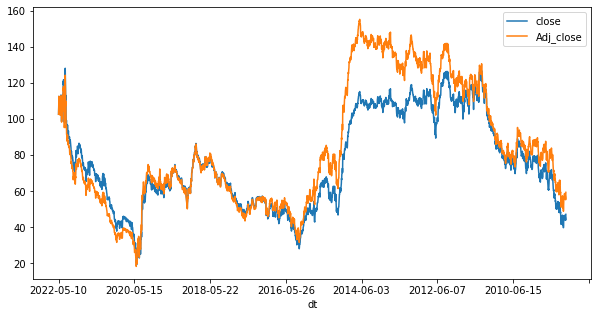

In [22]:
ohlcv_DF[:3350][['close','Adj_close']].plot(figsize=(10,5))

In [25]:
ohlcv_DF[ohlcv_DF['openInterest'] != 0]

,close,Adj_close,open,Adj_open,high,Adj_high,low,Adj_low,volume,openInterest
dt,,,,,,,,,,
2021-04-28,67.27,57.822572,67.27,57.822572,67.27,57.822572,67.27,57.822572,0.0,1000.0
2021-04-27,66.42,56.619188,66.42,56.619188,66.42,56.619188,66.42,56.619188,1000.0,1000.0
2021-04-26,65.65,55.962808,65.65,55.962808,65.65,55.962808,65.65,55.962808,1000.0,1000.0
2021-02-24,67.04,57.023795,67.04,57.023795,67.04,57.023795,67.04,57.023795,0.0,3000.0
2021-02-23,65.37,54.846276,65.37,54.846276,65.37,54.846276,65.37,54.846276,0.0,3000.0
...,...,...,...,...,...,...,...,...,...,...
2008-10-20,74.83,98.976049,74.83,98.976049,74.83,98.976049,74.83,98.976049,100.0,100.0
2008-08-22,117.90,155.943821,117.90,155.943821,117.90,155.943821,117.90,155.943821,37.0,37.0
2008-05-21,135.55,179.289100,135.55,179.289100,135.55,179.289100,135.55,179.289100,0.0,35.0


In [29]:
Switch_df[Switch_df['active'] == 'SCM22']

,active,Switch_dt,expiry_dt,Second_active
0,SCM22,2022-04-26,2022-04-28,SCN22


In [36]:
ohlcv_DF[8:]

,close,Adj_close,open,Adj_open,high,Adj_high,low,Adj_low,volume,openInterest
dt,,,,,,,,,,
2022-04-28,107.59,107.590000,107.59,107.590000,107.59,107.590000,107.59,107.590000,0.0,0.0
2022-04-27,105.32,105.320000,105.32,105.320000,105.32,105.320000,105.32,105.320000,0.0,0.0
2022-04-26,104.99,104.610000,104.99,104.610000,104.99,104.610000,104.99,104.610000,0.0,0.0
2022-04-25,102.32,101.949664,102.32,101.949664,102.32,101.949664,102.32,101.949664,0.0,0.0
2022-04-22,106.65,106.263992,106.65,106.263992,106.65,106.263992,106.65,106.263992,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2007-08-09,70.38,93.090128,70.38,93.090128,70.38,93.090128,70.38,93.090128,0.0,0.0
2007-08-08,70.43,93.156262,70.43,93.156262,70.43,93.156262,70.43,93.156262,0.0,0.0
2007-08-07,70.91,93.791148,70.91,93.791148,70.91,93.791148,70.91,93.791148,0.0,0.0
